In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

## Controlled Ordinary Differential Equations in plain jax

In this notebook, we show how to deal with *controlled* ordinary differential equations (ODEs):
\begin{equation}
\dot x(t) = f(x(t), u(t)),
\end{equation}
where the state $x(t)$ depends causally on a control input $u(t)$.

Here, we use basic jax tools, i.e. we do not rely on specialized ODE solvers like ``diffrax``. For simplicity, we limit ourself to a simple case where:

* The input signal $u(t)$ is regularly sampled with sampling time $t_s$ and assumed constant in each interval
* We use an explicit ODE solver and execute a single step on each interval

Overall, in this simplified settings, solving the ODE corresponds to simulating a discrete-time system. For instance, Forward Euler integration corresponds to the discrete-time system:
\begin{equation*}
x(k+1) = x(k) + t_s f(x(k), u(k)),
\end{equation*}
which we can iterat super efficiently with ``jax.lax.scan``!

For the sake of illustration, we use in this tutorial the (trivial) first-order linear ODE:

\begin{equation*}
\dot x = a x + bu.
\end{equation*}

We provide implementation for the Forward Euler (FE) and Runge Kutta of order 4 (RK4) integration schemes.

In [2]:
seed = 1234
key = jr.key(seed)
x0key, ukey = jr.split(key, 2) # keys for initial state & input signal

In [3]:
def f_xu(x, u, args):
    """ Toy system: first-order dynamics"""
    a = -0.1
    b = 1.0
    return a*x + b*u

In [4]:
# data
nx = 1 # number of states
nu = 1
dataset_size = 2_000 # number of sequences in the dataset
seq_len = 1_000 # length of each sequence (number of time steps, sampling time is irregular)
dt = 1e-1

In [5]:
ts = jnp.arange(seq_len) * dt
x0 = jr.uniform(x0key, (nx,))
u = jr.uniform(ukey, (seq_len, nu), minval=-1, maxval=1)

In [6]:
def discretize_rk4(fun_ct, dt):
    def fun_rk(x, u, args):
        dt2 = dt/2
        k1 = fun_ct(x, u, args)
        k2 = fun_ct(x + dt2 * k1, u, args)
        k3 = fun_ct(x + dt2 * k2, u, args)
        k4 = fun_ct(x + dt * k3, u, args)
        dx = dt / 6.0 * (k1 + 2.0 * k2 + 2.0 * k3 + k4)
        x_new = x + dx
        return x_new, x
    return fun_rk

def discretize_euler(fun_ct, dt):
    def fun_euler(x, u, args):
        k1 = fun_ct(x, u, args)
        dx = dt * k1
        x_new = x + dx
        return x_new, x
    return fun_euler

def solve_euler(fn_ct, ts, x0, u, args):
    fn_rk = discretize_euler(fn_ct, ts)
    _, x_sim = jax.lax.scan(lambda x, u: fn_rk(x, u, args), x0, u)
    return x_sim

def solve_rk4(fn_ct, ts, x0, u, args):
    fn_rk = discretize_rk4(fn_ct, ts)
    _, x_sim = jax.lax.scan(lambda x, u: fn_rk(x, u, args), x0, u)
    return x_sim

In [7]:
x_fe = solve_euler(f_xu, dt, x0, u, None)
x_rk = solve_rk4(f_xu, dt, x0, u, None)

In [8]:
# check what the manually implemented forward euler does.
step = 100
x_fe[step] - x_fe[step-1] - dt * f_xu(x_fe[step-1], u[step-1], None)

Array([1.8626451e-09], dtype=float32)

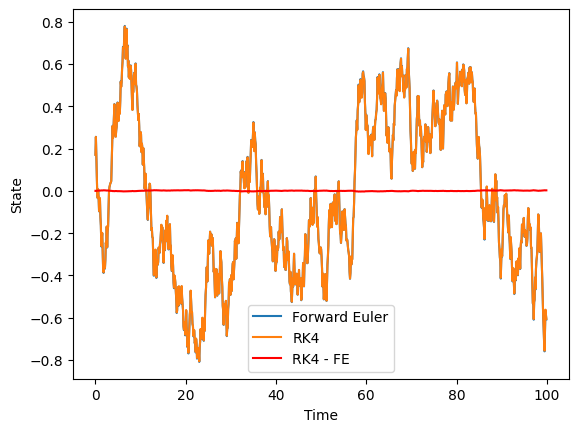

In [9]:
plt.figure()
plt.plot(ts, x_fe, label='Forward Euler')
plt.plot(ts, x_rk, label='RK4')
plt.plot(ts, x_rk - x_fe, "r", label='RK4 - FE')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()
plt.show()


Of course, if we have some data, we can set-up a parametric ODE, differentiate a fitting loss w.r.t. the tunable ODE parameters, and do *System Identification*!